<a href="https://colab.research.google.com/github/krymbeaulieu/CMPE_256_Book_Recommender/blob/main/shabab/Shabab_Project_Prediction_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505173 sha256=9038f5c76731ac59644f40da3e5c28b7a2af33e7900d7da96696aba83a735d78
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
try:
    import kagglehub
except ModuleNotFoundError:
    !pip install kagglehub
    import kagglehub
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

In [3]:
# Import all required libraries
# You might need to install the surprise package (pip install scikit-surprise)
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from surprise import NormalPredictor, KNNBasic, NMF, SlopeOne, SVD, Dataset
from surprise.model_selection import cross_validate

In [4]:
# Download latest version
path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")

print("Path to dataset files:", path)

100%|██████████| 24.3M/24.3M [00:00<00:00, 186MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/book-recommendation-dataset/versions/3


In [6]:
# get all the csv from the dataset
user_path = list(Path(path).glob("*User*.csv"))[0]
book_path = list(Path(path).glob("*Book*.csv"))[0]
rating_path = list(Path(path).glob("*Rating*.csv"))[0]
# load the csv as a dataframe
books_df = pd.read_csv(book_path,low_memory=False)
ratings_df = pd.read_csv(rating_path)
users_df = pd.read_csv(user_path)

In [7]:
# view the contents of the users dataframe
users_df.head()
# contains user_id, location, age

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
# view contents of the ratings dataframe
ratings_df.head()
# contents include the user_id, ISBN, and book rating

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
# view contents of the books dataframe
books_df.head()
# contents include ISBN, book title, book author, publication year, and publisher

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [10]:
# create a user rating dataframe by merging the users and ratings on the user_id
user_rating_df = pd.merge(users_df,ratings_df,on="User-ID")
user_rating_df.head()

,User-ID,Location,Age,ISBN,Book-Rating
0,2,"stockton, california, usa",18.0,0195153448,0
1,7,"washington, dc, usa",NaN,034542252,0
2,8,"timmins, ontario, canada",NaN,0002005018,5
3,8,"timmins, ontario, canada",NaN,0060973129,0
4,8,"timmins, ontario, canada",NaN,0374157065,0


In [11]:
# get the rating scale
print(f"(min, max) rating scale ({user_rating_df['Book-Rating'].min()}, {user_rating_df['Book-Rating'].max()})")
# rating scale is 0 - 10

(min, max) rating scale (0, 10)


In [12]:
# find the average book ratings for every user
mean_ratings = user_rating_df.groupby("User-ID")['Book-Rating'].mean()
# return the average ratings above a 5
mean_ratings[mean_ratings>5]

,Book-Rating
User-ID,
12,10.000000
19,7.000000
26,9.500000
42,7.000000
51,9.000000
...,...
278832,10.000000
278836,8.000000
278844,6.333333


In [13]:
user_rating_counts = user_rating_df.groupby("User-ID")['Book-Rating'].count()
print(f"(min, max) number of reviews ({user_rating_counts.min()}, {user_rating_counts.max()})")
print(sorted(user_rating_counts)[-20:])

(min, max) number of reviews (1, 13602)
[2421, 2448, 2459, 2504, 2507, 2512, 2529, 2674, 2948, 2991, 3067, 3100, 3367, 4533, 4785, 5850, 5891, 6109, 7550, 13602]


User-ID
11676    13602
Name: Book-Rating, dtype: int64


Text(0.5, 1.0, "User 11676 Most Reviews' Review Spread")

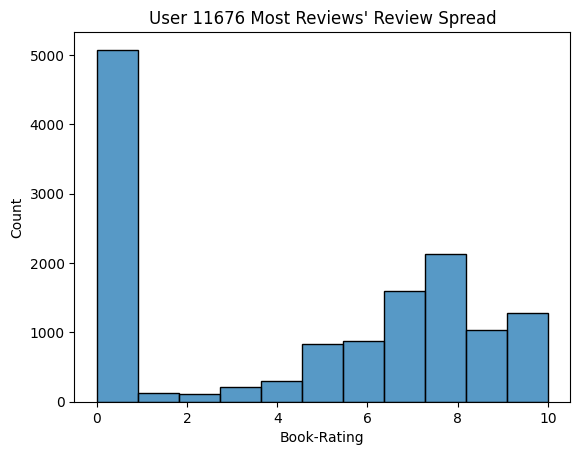

In [14]:
print(user_rating_counts[user_rating_counts == 13602])
# who is this person who rated 13602 books?!
# it is double the last rating!
sorted(user_rating_counts)[-10:]
user_rating_df[user_rating_df['User-ID']==11676]['Book-Rating'].mean()
ax = sns.histplot(user_rating_df[user_rating_df['User-ID']==11676]['Book-Rating'],bins=11)
ax.set_title("User 11676 Most Reviews' Review Spread")
# well.. this user has 5000 0 rating reviews.

Text(0.5, 1.0, "Histogram of Users' number of ratings")

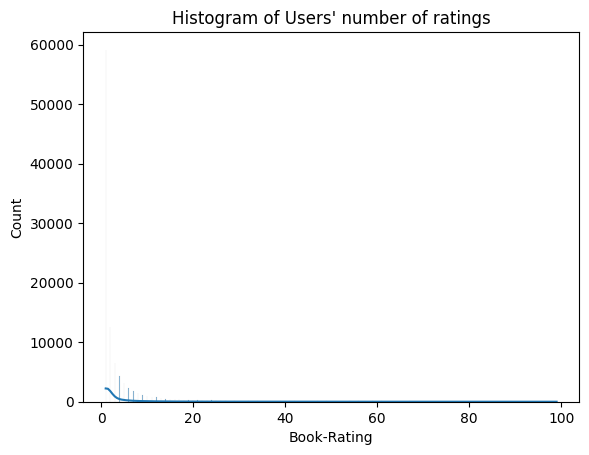

In [15]:
user_rating_counts = user_rating_df.groupby("User-ID")['Book-Rating'].count()
ax = sns.histplot(user_rating_counts[user_rating_counts<100],kde=True)
ax.set_title("Histogram of Users' number of ratings")

Text(0.5, 1.0, 'Histogram of mean book rating')

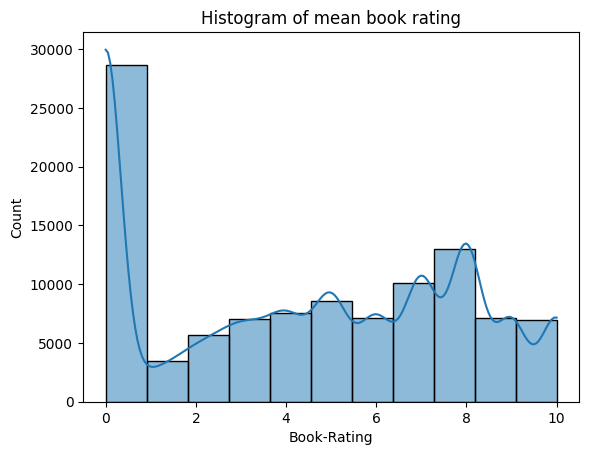

In [16]:
ax = sns.histplot(mean_ratings,bins=11,kde=True)
ax.set_title("Histogram of mean book rating")

In [17]:
# consolidate user ratings and books on ISBN
data = pd.merge(user_rating_df,books_df,on="ISBN")
data.head()

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,"stockton, california, usa",18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,8,"timmins, ontario, canada",NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,8,"timmins, ontario, canada",NaN,0060973129,0,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,8,"timmins, ontario, canada",NaN,0374157065,0,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,8,"timmins, ontario, canada",NaN,0393045218,0,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [18]:
data.describe()

,User-ID,Age,Book-Rating
count,1.031136e+06,753301.000000,1.031136e+06
mean,1.405945e+05,37.397648,2.839051e+00
std,8.052466e+04,14.098254,3.854157e+00
min,2.000000e+00,0.000000,0.000000e+00
25%,7.041500e+04,28.000000,0.000000e+00
50%,1.412100e+05,35.000000,0.000000e+00
75%,2.114260e+05,45.000000,7.000000e+00
max,2.788540e+05,244.000000,1.000000e+01


In [22]:
# Computes counts for ratings
data['counts'] = [1 for x in range(data.shape[0])]
data[['Book-Rating','counts']].groupby(by='Book-Rating').count().sort_values(by='counts',ascending=False).T

Book-Rating,0,8,10,7,9,5,6,4,3,2,1
counts,647294,91804,71225,66402,60778,45355,31687,7617,5118,2375,1481


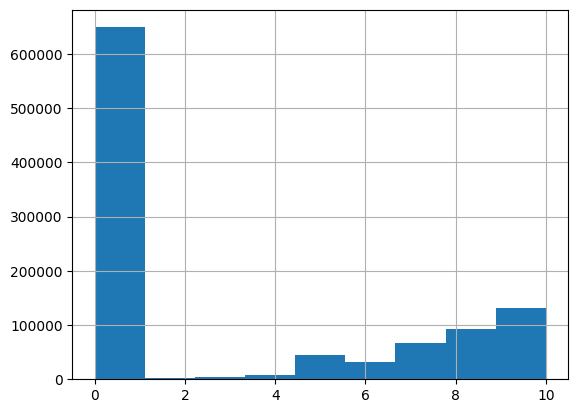

In [20]:
# Plots the histogram of ratings
tmp = data['Book-Rating'].hist(bins=9)

The data skews towards 0 (readers who read a book but did not leave a review)

In [23]:
# Computes counts for user ids (number of movies rated by each user)
data[['User-ID','counts']].groupby(by='User-ID').count().sort_values(by='counts',ascending=False).T

User-ID,11676,198711,153662,98391,35859,212898,278418,76352,110973,235105,...,278778,278781,64,68,70,73,77,78,79,81
counts,11144,6456,5814,5779,5646,4289,3996,3329,2971,2943,...,1,1,1,1,1,1,1,1,1,1


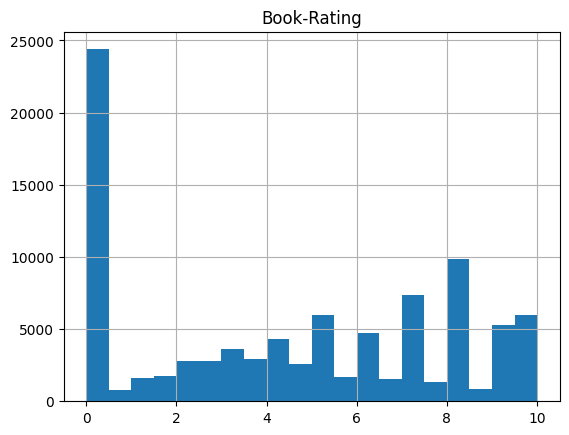

In [24]:
# Plots the histogram of average ratings per user
tmp = data[['User-ID','Book-Rating']].groupby(by='User-ID').mean().hist(bins=20)

In [25]:
# Computes counts for item ids (number of user ratings received by each movie)
data[['ISBN','counts']].groupby(by='ISBN').count().sort_values(by='counts',ascending=False).T

ISBN,0971880107,0316666343,0385504209,0060928336,0312195516,044023722X,0142001740,067976402X,0671027360,0446672211,...,0590661094,0590661388,0590662082,059066218X,0590664700,0590664719,0590664778,0590673262,0590673270,0590649337
counts,2502,1295,883,732,723,647,615,614,586,585,...,1,1,1,1,1,1,1,1,1,1


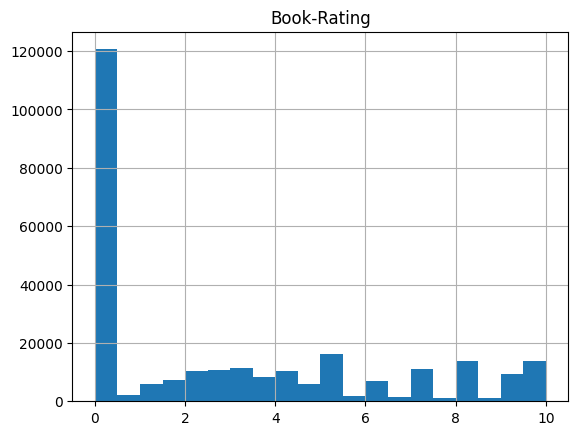

In [26]:
# Plots the histogram of average ratings per movie
tmp = data[['ISBN','Book-Rating']].groupby(by='ISBN').mean().hist(bins=20)

In [27]:
# Creates some variables to be used in the section
results = dict() # dictionary to collect results from the different simulations
errordict = {'RMSE':{'key':'test_rmse','name':'Root Mean Square Error'},
             'MAE':{'key':'test_mae','name':'Mean Absolute Error'}}

In [28]:
# Random predictions: RMSE and MAE computed for a 10-fold cross-validation exercise
algo = NormalPredictor()

from surprise import Reader, Dataset

# Assuming 'data' is your DataFrame with columns 'User-ID', 'ISBN', and 'Book-Rating'
reader = Reader(rating_scale=(data['Book-Rating'].min(), data['Book-Rating'].max()))
# Create the surprise Dataset object
data_surprise = Dataset.load_from_df(data[['User-ID', 'ISBN', 'Book-Rating']], reader)

# Now use data_surprise in cross_validate
scores = cross_validate(algo, data_surprise, measures=['RMSE','MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    4.9180  4.8978  4.9119  4.9107  4.9013  4.8904  4.9010  4.8880  4.8971  4.9086  4.9025  0.0092  
MAE (testset)     3.8802  3.8683  3.8849  3.8769  3.8646  3.8557  3.8624  3.8564  3.8588  3.8762  3.8684  0.0100  
Fit time          1.01    1.40    1.43    1.43    1.43    1.41    1.44    1.45    1.43    1.46    1.39    0.13    
Test time         0.71    1.23    0.73    0.70    1.26    0.71    0.70    0.69    1.28    0.70    0.87    0.25    


#Try training with SVD

In [33]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# create a train test split from the data
# using a 75/25 train/test split
trainset, testset = train_test_split(data_surprise, test_size=0.25)

In [34]:
# create an SVD trainer and fit on the train set
algo = SVD()
algo.fit(trainset)

In [35]:
# make predictions on the test set
predictions = algo.test(testset)

In [36]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 3.5054
MAE:  2.8118


2.8118321481639006

In [48]:
def get_title_from_isbn(isbn):
  # get the associated book title from the ISBN
  return books_df[books_df['ISBN'] == isbn]['Book-Title'].values[0]

def get_isbn_from_title(title):
  # get the associated ISBN from the book title
  return books_df[books_df['Book-Title'] == title]['ISBN'].values[0]

def make_prediction_isbn(user_id, isbn):
  # get the book title from the specified isbn
  title = get_title_from_isbn(isbn)
  # get a prediction from the user id and the given isbn
  predicted_rating = algo.predict(user_id, isbn).est
  print(f"Predicted rating for user {user_id} for '{title}' (ISBN: {item_id}): {predicted_rating}")

def make_prediction_book_title(user_id, book_title):
  # get the book title from the specified isbn
  isbn = get_isbn_from_title(book_title)
  # get a prediction from the user id and the given isbn
  predicted_rating = algo.predict(user_id, isbn).est
  print(f"Predicted rating for user {user_id} for '{book_title}' (ISBN: {item_id}): {predicted_rating}")

In [49]:
user_id = "278854"
isbn = "0425163393"
make_prediction_isbn(user_id, isbn)

Predicted rating for user 278854 for 'Kat Scratch Fever (Kat Colorado Mysteries)' (ISBN: 0425163393): 3.1455927112464988


In [50]:
user_id = "278854"
book_title = "Classical Mythology"
make_prediction_book_title(user_id, book_title)

Predicted rating for user 278854 for 'Classical Mythology' (ISBN: 0425163393): 2.5964153829212657


In [51]:
data

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,counts
0,2,"stockton, california, usa",18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,1
1,8,"timmins, ontario, canada",NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,1
2,8,"timmins, ontario, canada",NaN,0060973129,0,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,1
3,8,"timmins, ontario, canada",NaN,0374157065,0,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,1
4,8,"timmins, ontario, canada",NaN,0393045218,0,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,278854,"portland, oregon, usa",NaN,0425163393,7,Kat Scratch Fever (Kat Colorado Mysteries),Karen Kijewski,1998,Berkley Publishing Group,http://images.amazon.com/images/P/0425163393.0...,http://images.amazon.com/images/P/0425163393.0...,http://images.amazon.com/images/P/0425163393.0...,1
1031132,278854,"portland, oregon, usa",NaN,0515087122,0,The Cat Who Ate Danish Modern (Cat Who... (Pap...,Lilian Jackson Braun,1990,Jove Books,http://images.amazon.com/images/P/0515087122.0...,http://images.amazon.com/images/P/0515087122.0...,http://images.amazon.com/images/P/0515087122.0...,1
1031133,278854,"portland, oregon, usa",NaN,0553275739,6,In Her Day,Rita Mae Brown,1988,Bantam Books,http://images.amazon.com/images/P/0553275739.0...,http://images.amazon.com/images/P/0553275739.0...,http://images.amazon.com/images/P/0553275739.0...,1
1031134,278854,"portland, oregon, usa",NaN,0553578596,0,Wicked Fix : A Home Repair is Homicide Mystery...,SARAH GRAVES,2000,Bantam,http://images.amazon.com/images/P/0553578596.0...,http://images.amazon.com/images/P/0553578596.0...,http://images.amazon.com/images/P/0553578596.0...,1
